# Trabajo de módulo: Aprendizaje Reforzado
## Desarrollo de un modelo para solucionar el entorno 'LunarLander-v2' 
### Por: Luis Palma

In [8]:
# Cargar librerias
import gym                      # entorno del juego
import numpy as np              # manejo de matrices
import torch                    # para el uso de Pytorch
import torch.nn as nn           # cargar nn 
import torch.optim as optim     # cargar optim de torch
import random                   # para la generación de numeros aleatorios
from collections import deque   # para el replay buffer
import time                     # para medir el tiempo de ejecución por episodio

# Configuración del entorno
env = gym.make('LunarLander-v2')                # crear entorno de juego
state_size = env.observation_space.shape[0]     # tamaño de los estados
action_size = env.action_space.n                # número de acciones disponibles en el entorno

# Hiperparámetros
n_episodes = 1000           # Aunque puede escogerse un número más grande, se fija 1000 para comparar con otros modelos y arquitecturas
batch_size = 64             # tamaño del lote (batch)
memory_size = 10000         # tamaño de la memoria
gamma = 0.99                # Factor de descuento
epsilon = 1.0               # Tasa de exploración inicial
epsilon_min = 0.05          # Tasa de exploración mínima
epsilon_decay = 0.996       # Tasa de decaimiento de la tasa de exploración
learning_rate = 0.001       # tasa de aprendizaje de la red

# Creación del modelo de red neuronal principal
class DQN(nn.Module):                               # Creamos la clase 'DQN' que se hereda de 'nn.Module' 
    def __init__(self, state_size, action_size):    # Declaración del método init de la clase y declaración de argumentos de la clase 
        super(DQN, self).__init__()                 # declaración de herencia 
        self.fc1 = nn.Linear(state_size, 256)       # Declaración de la capa de entrada de tamaño state_size=8, y salida de 256
        self.fc2 = nn.Linear(256, 256)              # Declaración de capa oculta de 256 neuronas de entrada y salida  
        self.fc3 = nn.Linear(256, action_size)      # Declaración de capa de 256 y de salida action_size = 4

    def forward(self, x):           # Declaración del método forward x serán los state convertidos a tensor
        x = torch.relu(self.fc1(x)) # aplica una función de activación reLU a la capa fc1
        x = torch.relu(self.fc2(x)) # aplica una función de activación reLU a la capa fc2
        x = self.fc3(x)             # pasa por la última capa sin aplicar una función de activación, porque se espera que sea una combinación lineal de su entrada y los pesos aprendidos
        return x                    # devuelve el resultado de la propagación de los datos por la red

model = DQN(state_size, action_size)                            # Crea una instancia del modelo de red 'DQN' con los argumentos state_size y action_size, este es el modelo principal
optimizer = optim.Adam(model.parameters(), lr=learning_rate)    # Se crea un optimizador Adam

# Creación del modelo de red neuronal objetivo
target_model = DQN(state_size, action_size)         # Con este modelo se harán las predicciones es equivalente al modelo principal
target_model.load_state_dict(model.state_dict())    # Inicializa los pesos del target_model con los del modelo principal

# Creación del replay buffer
memory = deque(maxlen=memory_size)                  # Instanciación del buffer en un objeto deque de tamaño memory_size

# Función de acción epsilon-greedy
def epsilon_greedy_action(state, epsilon):                      # Declaración de una función con argumentos state, epilon que dedicidirá si explorar o explotar el entorno
    if np.random.rand() <= epsilon:                             # si un número aleatorio es menor o igual que el epilon
        return env.action_space.sample()                        # Explora! (devuelve una acción aleatoria)
    else:                                                       # si no... Explota! 
        state = torch.from_numpy(state).float().unsqueeze(0)    # convertir el state de numpy a tensor y agrega una dimensión para utilizarse como entrada de la red neuronal
        with torch.no_grad():                                   # No actualizar gradientes 
            q_values = model(state)                             # Inferencia del modelo y obtener el q_value de cada acción
        return torch.argmax(q_values).item()                    # Devuelve la posición que tiene el máximo valor de acción

# Listas de evolución                                           # Crear listas vacias para guardar datos y rendimientos     
reward_per_episode = []                                         # recompensa por episodio
epsilon_evolution = []                                          # evolución del epsilon
actions_per_episode = []                                        # Acciones por episodio
time_per_episode = []                                           # tiempo en segundos por episodio

# Entrenamiento del agente
for episode in range(n_episodes):                            # Declaración del bucle con n_episodes episodios
    start_time = time.time()                                 # Declararación de hora inicial de inicio del bucle
    state = env.reset()                                      # reinicio del entorno al iniciar el bucle
    total_reward = 0                                         # Reinicio a cero del objeto total_reward
    done = False                                             # Reinicio a False la variable de condición de finalización del episodio
    act = 0                                                  # Reinicio a cero del número de acciones por episodio

    while not done:                                             # Inicio del Juego (Mientras no termine)
        if episode % 50==0:                                   # Si el número de episodio es múltiplo de 50 
            env.render()                                      # Renderizar
        act += 1                                                # Sumar una acción 

        # Elegir acción
        action = epsilon_greedy_action(state, epsilon)              # Escoge una acción mediante la politica epsilon-greedy

        # Realizar acción y obtener siguiente estado, recompensa y estado de finalización
        next_state, reward, done, _ = env.step(action)              # Obtener la siguiente observación, recompensa y si finaliza 

        # Almacenar la transición en el replay buffer
        memory.append((state, action, reward, next_state, done))    # Guardar en memory: el estado, acción, recompensa, estado siguiente y finalización o no. 

        # Actualizar estado actual
        state = next_state                                          # Guardar como estado el siguiente estado 
        total_reward += reward                                      # sumar a total_reward la recompensa de la acción

        # Actualizar la red neuronal utilizando el replay buffer
        if len(memory) > batch_size:                                                # Comprobar si el tamaño de la memoria es mayor que el tamaño 'batch_size':
            batch = random.sample(memory, batch_size)                               # Guardar en el batch la cantidad de 'batch_size' datos aleatorios 
            states, actions, rewards, next_states, dones = zip(*batch)              # las transiciones se descomprinen en cinto listas:  'states', 'actions', 'rewards', 'next_states', 'dones'

            states = torch.tensor(states, dtype=torch.float32)                      # convertir a tensores
            actions = torch.tensor(actions)                                         # convertir a tensores
            rewards = torch.tensor(rewards, dtype=torch.float32)                    # convertir a tensores
            next_states = torch.tensor(next_states, dtype=torch.float32)            # convertir a tensores
            dones = torch.tensor(dones, dtype=torch.float32)                        # convertir a tensores

            current_q_values = model(states).gather(1, actions.unsqueeze(1))        # obtener los Q actuales del modelo de red neuronal para los estados y acciones del batch. 
            next_q_values = target_model(next_states).max(1)[0].detach()            # obtener los Q siguientes del modelo de red neuronal objetivo target_model y se pone el máximo valor de cada uno en un tensor
            target_q_values = rewards + gamma * next_q_values * (1 - dones)         # obtener los Q objetivo, se calculan la fórmula de actualización del algoritmo DQN: recompensas actuales, más el factor de descuento multiplicado por los valores Q siguientes, teniendo en cuenta si el episodio ha finalizado

            loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))     # cálculo de la pérdida utilizando el MSE
            optimizer.zero_grad()                                                   # reinicio de gradientes de la red a cero
            loss.backward()                                                         # Retropropagación de la pérdida
            optimizer.step()                                                        # Actualización de los parámetros del modelo

        # Actualizar tasa de exploración
        if epsilon > epsilon_min:                                                   # Comprobar si epsilon es mayor que el epsilon_min
            epsilon *= epsilon_decay                                                # Multiplicar el epsilon por la tasa de decaimiento de la tasa de exploración

    # Actualizar el modelo objetivo al final de cada episodio
    if episode % 10 == 0:                                                           # Cada 10 episodios 
        target_model.load_state_dict(model.state_dict())                            # actualizar el target_model con los pesos del model 

    # Guardar registros de rendimiento del modelo
    end_time = time.time()  # Obtener el tiempo de finalización                     # Guardar la hora de finalización del bucle while
    execution_time = end_time - start_time                                          # diferencia de hora final menos hora iniical
    time_per_episode.append(round(execution_time,1))                                # Guardar el tiempo de ejecución en la lista time_per_episode
    reward_per_episode.append(total_reward)                                         # Guardar la Recompensa total en la lista reward_per_episode 
    actions_per_episode.append(act)                                                 # Guardar el número de acciones en la lista actions_per_episode
    epsilon_evolution.append(epsilon)                                               # Guardar el epsilon en la lista epsilon_evolution
    print("Episodio:", episode, "| Recompensa total:", total_reward, "| Acciones/episodio: ", act, "| Segundos/episodio: ", execution_time) # imprime la evolución

env.close()

2023-06-23 00:03:06.648 python[13068:16796442] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7d308682b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-06-23 00:03:06.648 python[13068:16796442] Warning: Expected min height of view: (<NSButton: 0x7f7d30756720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-06-23 00:03:06.652 python[13068:16796442] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7d30761da0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-06-23 00:03:06.654 python[13068:16796442] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7d306c72d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-06-23 00:03:08.161

Episodio: 0 | Recompensa total: -135.7803811678254 | Acciones/episodio:  84 | Segundos/episodio:  10.935180187225342
Episodio: 1 | Recompensa total: -99.24004276449753 | Acciones/episodio:  116 | Segundos/episodio:  0.6005001068115234
Episodio: 2 | Recompensa total: -230.42930155567873 | Acciones/episodio:  169 | Segundos/episodio:  0.8782031536102295
Episodio: 3 | Recompensa total: -145.46394286744345 | Acciones/episodio:  95 | Segundos/episodio:  0.383206844329834
Episodio: 4 | Recompensa total: -804.6725767076018 | Acciones/episodio:  263 | Segundos/episodio:  0.9307851791381836
Episodio: 5 | Recompensa total: -224.20125234504098 | Acciones/episodio:  111 | Segundos/episodio:  0.3897089958190918
Episodio: 6 | Recompensa total: -439.1741940146939 | Acciones/episodio:  164 | Segundos/episodio:  0.5620691776275635
Episodio: 7 | Recompensa total: -418.2666635961503 | Acciones/episodio:  172 | Segundos/episodio:  0.5832979679107666
Episodio: 8 | Recompensa total: -619.0022965889717 | Acc

2023-06-23 00:22:07.233 python[13068:16796442] Warning: Window move completed without beginning


Episodio: 400 | Recompensa total: -52.34828641463299 | Acciones/episodio:  1000 | Segundos/episodio:  16.742253065109253
Episodio: 401 | Recompensa total: -65.8028371784241 | Acciones/episodio:  1000 | Segundos/episodio:  4.636795997619629
Episodio: 402 | Recompensa total: -8.222420843909905 | Acciones/episodio:  1000 | Segundos/episodio:  4.414182901382446
Episodio: 403 | Recompensa total: -78.52499281387823 | Acciones/episodio:  1000 | Segundos/episodio:  5.7232911586761475
Episodio: 404 | Recompensa total: -6.704021560053415 | Acciones/episodio:  1000 | Segundos/episodio:  4.063611268997192
Episodio: 405 | Recompensa total: -99.85610718645752 | Acciones/episodio:  1000 | Segundos/episodio:  4.363969087600708
Episodio: 406 | Recompensa total: -15.827382025083338 | Acciones/episodio:  1000 | Segundos/episodio:  5.145870208740234
Episodio: 407 | Recompensa total: -18.24204199596646 | Acciones/episodio:  1000 | Segundos/episodio:  4.088781118392944
Episodio: 408 | Recompensa total: 18.7

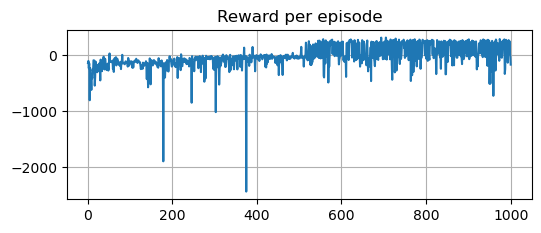

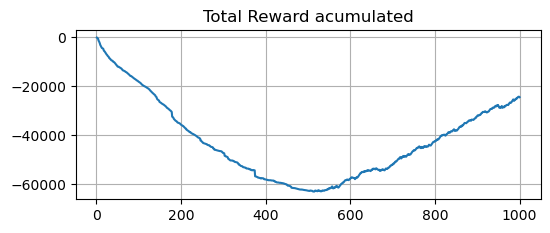

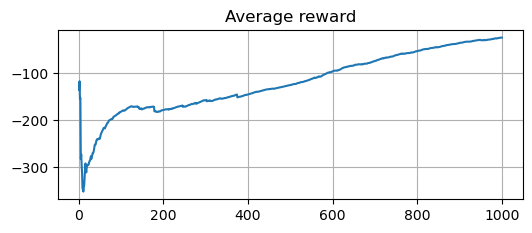

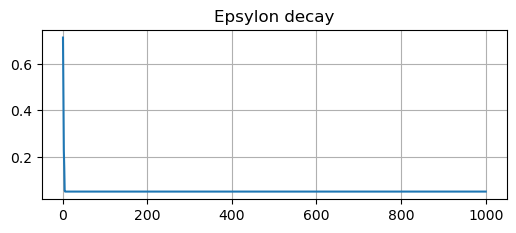

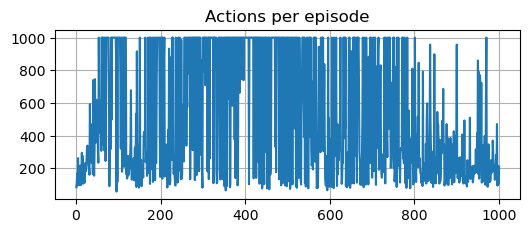

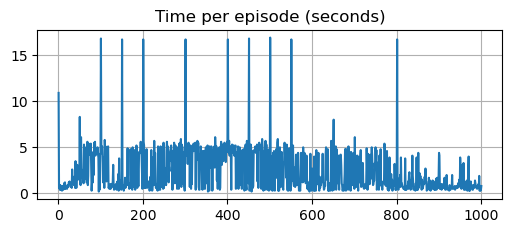

In [9]:
def plot_development_performance():
    import matplotlib.pyplot as plt
    fig_size = (6,2.2)

    # Reward per epidode
    plt.figure(figsize=fig_size)
    plt.plot(range(1,1+len(reward_per_episode)), reward_per_episode)
    plt.title("Reward per episode")
    plt.grid()
    plt.show()

    # Total Reward acumulated
    total_reward_acum = [sum(reward_per_episode[:i+1]) for i in range(len(reward_per_episode))]
    plt.figure(figsize=fig_size)
    plt.plot(range(1,1+len(total_reward_acum)), total_reward_acum)
    plt.title("Total Reward acumulated")
    plt.grid()
    plt.show()

    # Average reward
    plt.figure(figsize=fig_size)
    average_reward = [i/(ix+1) for ix,i in enumerate(total_reward_acum)]
    plt.plot(range(1,1+len(average_reward)), average_reward)
    plt.title("Average reward")
    plt.grid()
    plt.show()

    # Epsylon evolution
    plt.figure(figsize=fig_size)
    plt.plot(range(1,1+len(epsilon_evolution)), epsilon_evolution)
    plt.title("Epsylon decay")
    plt.grid()
    plt.show()

    # Actions per episode
    plt.figure(figsize=fig_size)
    plt.plot(range(1,1+len(actions_per_episode)), actions_per_episode)
    plt.title("Actions per episode")
    plt.grid()
    plt.show()

    # Time per episode (secondes)
    plt.figure(figsize=fig_size)
    plt.plot(range(1,1+len(time_per_episode)), time_per_episode)
    plt.title("Time per episode (seconds)")
    plt.grid()
    plt.show()
plot_development_performance()

## Otras pruebas realizadas: esta parte no esta bien revisada y puede tener errores
Aquí había intentado realizar el modelo con una red hecha con tensorflow, pero iba muuuy lento. 

In [6]:
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from tqdm import tqdm
import time

# Configuración del entorno
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Hiperparámetros
n_episodes = 50
batch_size = 64
memory_size = 10000
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Tasa de exploración
epsilon_min = 0.05
epsilon_decay = 0.996
learning_rate = 0.001

# Creación del modelo de red neuronal principal
model = Sequential()
model.add(Dense(256, input_dim=state_size, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

# Creación del modelo de red neuronal objetivo
target_model = Sequential()
target_model.add(Dense(256, input_dim=state_size, activation='relu'))
target_model.add(Dense(256, activation='relu'))
target_model.add(Dense(256, activation='relu'))
target_model.add(Dense(action_size, activation='linear'))
target_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

# Creación del replay buffer
memory = deque(maxlen=memory_size)

# Función de acción epsilon-greedy
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(model.predict(state, verbose=False))

# Listas de evolución
reward_per_episode = []
total_reward_acum =[]
average_reward = []
epsilon_evolution = []
actions_per_episode = []
time_per_episode = []

# Entrenamiento del agente
for episode in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    act = 0
    start_time = time.time() 

    while not done:
        # if episode % 10==0:
        #     env.render()

        # Elegir acción
        act += 1
        action = epsilon_greedy_action(state, epsilon)
        
        # Realizar acción y obtener siguiente estado, recompensa y estado de finalización
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Almacenar la transición en el replay buffer
        memory.append((state, action, reward, next_state, done))

        # Actualizar estado actual
        state = next_state
        total_reward += reward
                
        # Actualizar la red neuronal utilizando el replay buffer
        # if len(memory) > batch_size:
        #     batch = random.sample(memory, batch_size)
        #     for state, action, reward, next_state, done in batch:
        #         target = reward
        #         if not done:
        #             target = reward + gamma * np.amax(target_model.predict(next_state, verbose=False)[0])
        #         target_f = model.predict(state, verbose=False)
        #         target_f[0][action] = target
        #     model.fit(state, target_f, epochs=1, verbose=False)
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states = []
            targets = []
            for state, action, reward, next_state, done in batch:
                target = reward
                if not done:
                    target = reward + gamma * np.amax(target_model.predict(next_state, verbose=False)[0])
                target_f = model.predict(state, verbose=False)
                target_f[0][action] = target
                states.append(state[0])
                targets.append(target_f[0])
            model.fit(np.array(states), np.array(targets), epochs=1, verbose=False)

        # Actualizar tasa de exploración
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Actualizar el modelo objetivo al final de cada episodio
    target_model.set_weights(model.get_weights())

    # Guardar registros de rendimiento del modelo 
    end_time = time.time()  # Obtener el tiempo de finalización
    execution_time = end_time - start_time 
    time_per_episode.append(execution_time)
    reward_per_episode.append(total_reward)
    actions_per_episode.append(act)
    epsilon_evolution.append(epsilon)
    print("Episodio:", episode, "| Recompensa total:", total_reward, "| Acciones/episodio: ", act, "| Segundos/episodio: ", execution_time)

env.close()

2023-06-22 17:23:32.313006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 17:23:36.700935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Episodio: 0 | Recompensa total: -609.3153510644223 | Acciones/episodio:  149 | Segundos/episodio:  386.3140470981598
Episodio: 1 | Recompensa total: -0.3728497923552867 | Acciones/episodio:  3 | Segundos/episodio:  13.584734916687012
Episodio: 2 | Recompensa total: -390.14534706035397 | Acciones/episodio:  60 | Segundos/episodio:  276.66310000419617
Episodio: 3 | Recompensa total: -18.945113551013335 | Acciones/episodio:  18 | Segundos/episodio:  82.13389229774475
Episodio: 4 | Recompensa total: -12.43695486224722 | Acciones/episodio:  39 | Segundos/episodio:  179.86586594581604
Episodio: 5 | Recompensa total: -1.2865645140942743 | Acciones/episodio:  19 | Segundos/episodio:  89.74706196784973
Episodio: 6 | Recompensa total: 1.626599035821543 | Acciones/episodio:  13 | Segundos/episodio:  62.22338604927063
Episodio: 7 | Recompensa total: -89.6369626440293 | Acciones/episodio:  38 | Segundos/episodio:  189.42044711112976
Episodio: 8 | Recompensa total: -6.045658375243216 | Acciones/epis

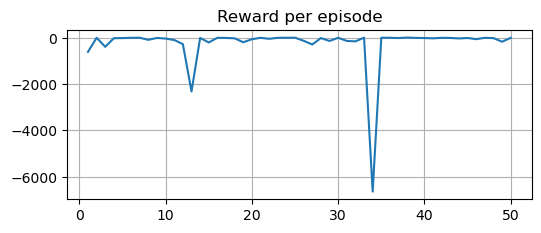

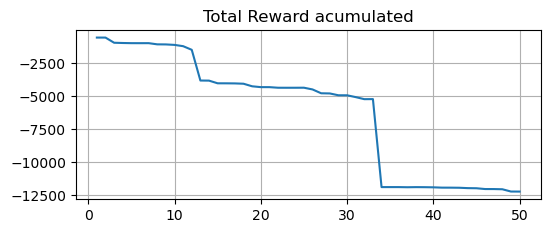

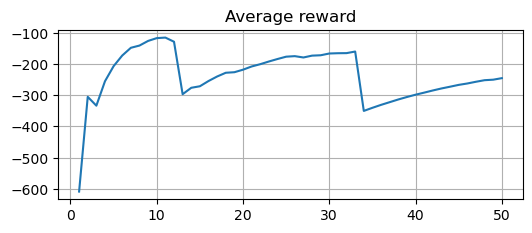

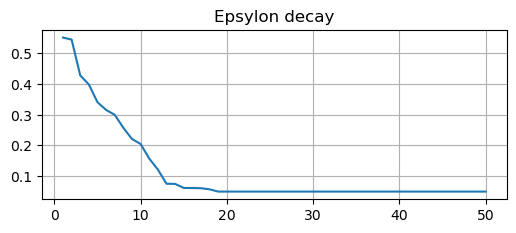

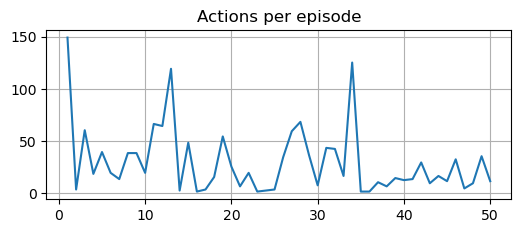

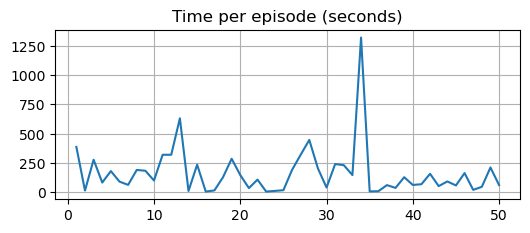

In [7]:
plot_development_performance()